In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

In [40]:
df =pd.read_csv('Electric_Production.csv', parse_dates=True)


In [41]:
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [42]:
# df.columns = ['Production']
# df.head()

In [43]:
df.shape

(397, 2)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [45]:
df['DATE'] = pd.to_datetime(df['DATE'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        397 non-null    datetime64[ns]
 1   IPG2211A2N  397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


In [46]:
df.set_index('DATE', inplace=True)

In [47]:
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [48]:
df.columns = ['Production']

In [49]:
df.head()

,Production
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


<Axes: xlabel='DATE'>

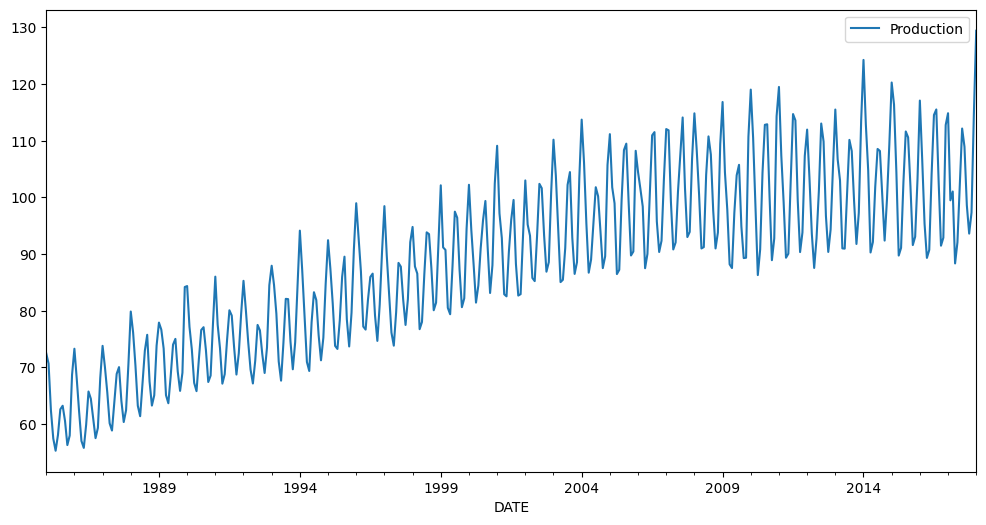

In [50]:
df.plot(figsize=(12,6))

In [51]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("\nWeak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [52]:
adf_test(df['Production'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.256990
p-value                   0.186215
# lags used              15.000000
# observations          381.000000
critical value (1%)      -3.447631
critical value (5%)      -2.869156
critical value (10%)     -2.570827

Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [53]:
df['Order_12'] = df['Production'] - df['Production'].shift(12)

df.head(14)


,Production,Order_12
DATE,,
1985-01-01,72.5052,NaN
1985-02-01,70.6720,NaN
1985-03-01,62.4502,NaN
1985-04-01,57.4714,NaN
1985-05-01,55.3151,NaN
1985-06-01,58.0904,NaN
1985-07-01,62.6202,NaN
1985-08-01,63.2485,NaN
1985-09-01,60.5846,NaN


In [54]:
adf_test(df['Order_12'][12:])

Augmented Dickey-Fuller Test: 
ADF test statistic     -5.673482e+00
p-value                 8.812645e-07
# lags used             1.200000e+01
# observations          3.720000e+02
critical value (1%)    -3.448052e+00
critical value (5%)    -2.869341e+00
critical value (10%)   -2.570926e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [57]:
adf_test(df['Order_12'].dropna())

Augmented Dickey-Fuller Test: 
ADF test statistic     -5.673482e+00
p-value                 8.812645e-07
# lags used             1.200000e+01
# observations          3.720000e+02
critical value (1%)    -3.448052e+00
critical value (5%)    -2.869341e+00
critical value (10%)   -2.570926e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


<Axes: xlabel='DATE'>

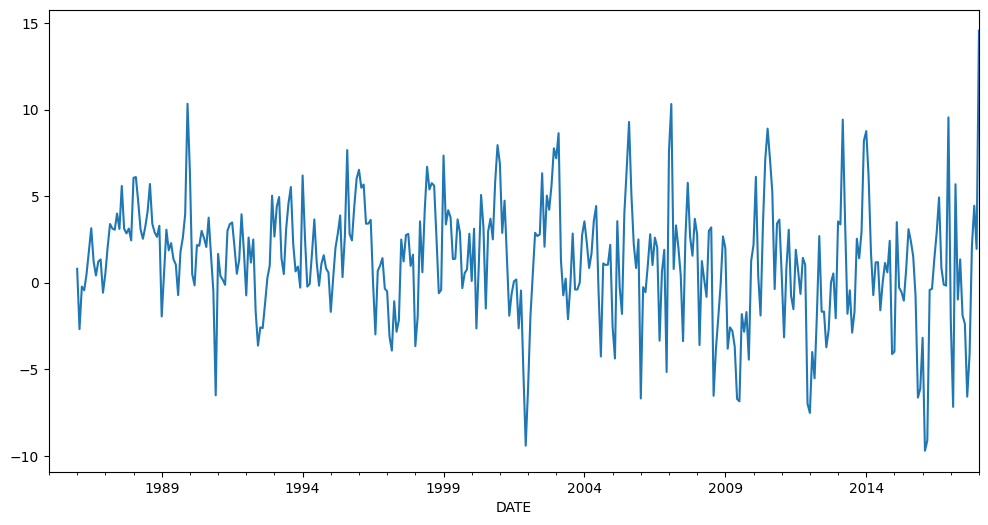

In [58]:
df['Order_12'].plot(figsize=(12,6))

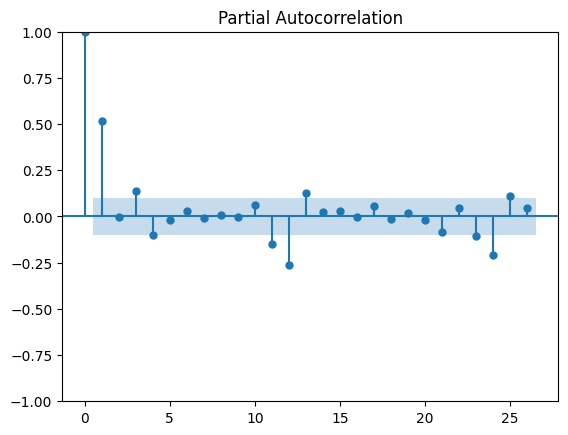

In [60]:
#PACF PLOT
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
pacf = plot_pacf(df['Order_12'].dropna())

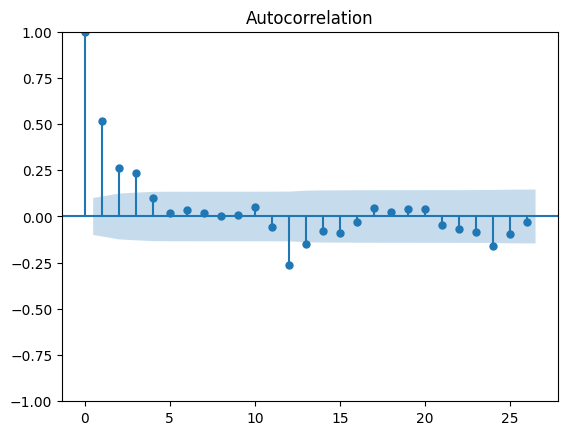

In [61]:
# ACF PLOT
acf = plot_acf(df['Order_12'].dropna())

In [76]:
# df_clean = df['Order_12'].dropna()
# stepwise_fit = auto_arima(df_clean, start_p=0, start_q=0, max_p=2, max_q=2, seasonal=False, trace=True)

# stepwise_fit.summary()
#AUTO ARIMA MODEL FOR BEST PARAMETR
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['Production'], seasonal = True, m = 12)
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  397
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -925.807
Date:                              Tue, 13 May 2025   AIC                           1863.613
Time:                                      12:56:17   BIC                           1887.502
Sample:                                  01-01-1985   HQIC                          1873.077
                                       - 01-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3546      0.091      3.889      0.000       0.176       0.533
ma.L1         -0.7259      0.090     -8.082      0.000      -0.902      -0.550
ma.L2         -0.2116      0.079     -2.682      0.007      -0.366      -0.057
ar.S.L12       0.9958      0.003    307.382      0.000       0.989       1.002
ma.S.L12      -0.7616      0.038    -20.146      0.000      -0.836      -0.688
sigma2         5.7575      0.326     17.641      0.000       5.118       6.397
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                28.04
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               2.99   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
train = df[:315]
test = df[315:]

In [78]:
order = stepwise_fit.order
order

(1, 1, 2)

In [79]:
#FIT THE SARIMAX MODEL USING BEST PARAMETRS
model = SARIMAX(train['Production'],
               order =order,
               seasonal_order=stepwise_fit.seasonal_order)

In [80]:
fitted_model= model.fit(disp = True)

In [82]:
print(fitted_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           Production   No. Observations:                  315
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -707.377
Date:                              Tue, 13 May 2025   AIC                           1426.754
Time:                                      12:56:49   BIC                           1449.250
Sample:                                  01-01-1985   HQIC                          1435.743
                                       - 03-01-2011                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2694      0.117      2.307      0.021       0.040       0.498
ma.L1         -0.64

In [83]:
test.head()


,Production,Order_12
DATE,,
2011-04-01,89.3583,3.0583
2011-05-01,90.0698,-0.7666
2011-06-01,102.8204,-1.5334
2011-07-01,114.7068,1.9002
2011-08-01,113.5958,0.6944


In [84]:
pred = fitted_model.predict(start = test.index[0], end = test.index[-1])

In [85]:
test['Sarimax_pred'] = pred

In [86]:
test.head()

,Production,Order_12,Sarimax_pred
DATE,,,
2011-04-01,89.3583,3.0583,90.161578
2011-05-01,90.0698,-0.7666,92.189439
2011-06-01,102.8204,-1.5334,103.024817
2011-07-01,114.7068,1.9002,110.646268
2011-08-01,113.5958,0.6944,111.425811


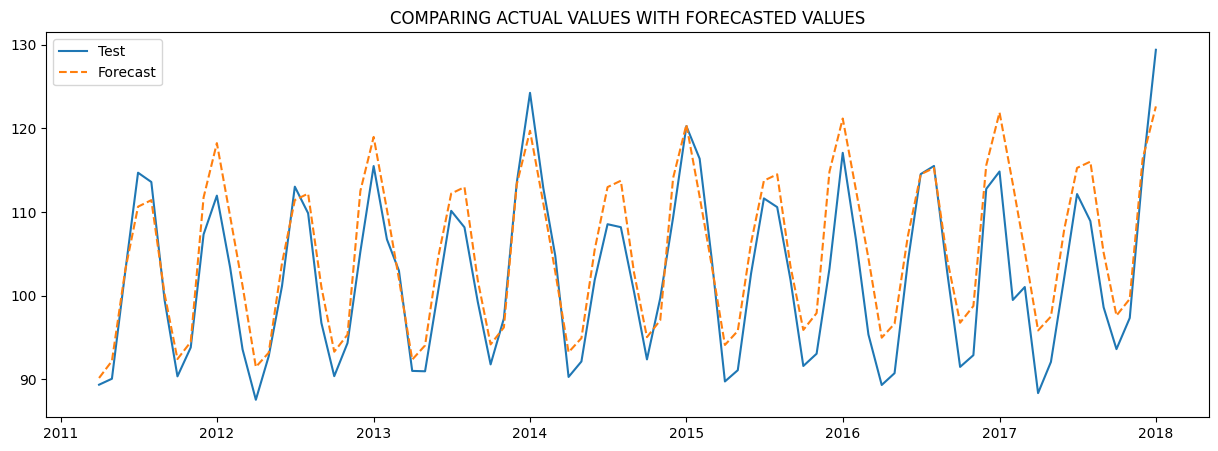

In [87]:
# PLOTTING ACTUAL VS FORECASTED VALUE
plt.figure(figsize=(15, 5))
plt.plot(test.index, test['Production'], label='Test')
plt.plot(test.index, test['Sarimax_pred'], label='Forecast', linestyle='--')
plt.title('COMPARING ACTUAL VALUES WITH FORECASTED VALUES');
plt.legend()

# Prediction in future 

In [88]:
model = SARIMAX(df['Production'], order = order, seasonal_order = stepwise_fit.seasonal_order)
results = model.fit(disp = True)
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           Production   No. Observations:                  397
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -925.807
Date:                              Tue, 13 May 2025   AIC                           1863.613
Time:                                      13:09:11   BIC                           1887.502
Sample:                                  01-01-1985   HQIC                          1873.077
                                       - 01-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3546      0.091      3.889      0.000       0.176       0.533
ma.L1         -0.7259      0.090     -8.082      0.000      -0.902      -0.550
ma.L2         -0.2116      0.079     -2.682      0.007      -0.366      -0.057
ar.S.L12       0.9958      0.003    307.382      0.000       0.989       1.002
ma.S.L12      -0.7616      0.038    -20.146      0.000      -0.836      -0.688
sigma2         5.7575      0.326     17.641      0.000       5.118       6.397
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                28.04
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               2.99   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [90]:
len(df)

397

In [91]:
pred = results.predict(start = df.index[0], end = len(df) + 12,type = 'levels').rename('Sarimax_pred')



<Axes: xlabel='DATE'>

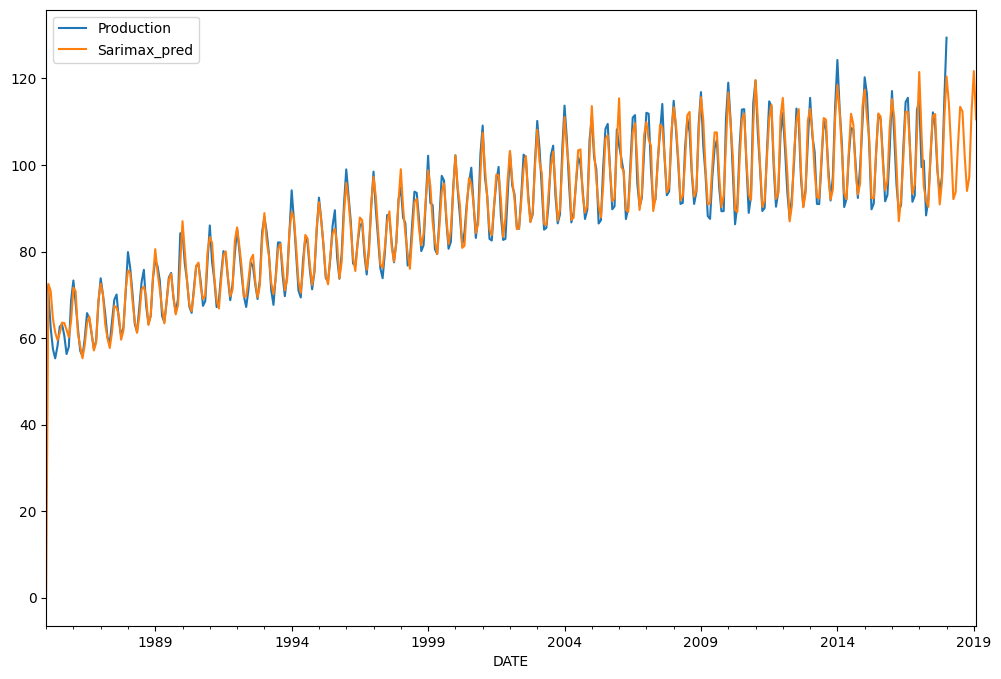

In [93]:
df['Production'].plot(figsize=(12,8),legend=True)
pred.plot(legend=True)
